<a href="https://colab.research.google.com/github/blondeincode/Cryptocurrency_price_prediction_ARIMA_model/blob/main/Bitcoin_price_prediction_ARIMA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import urllib.request
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.rcParams['figure.figsize'] = (18,6)
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.titlesize'] = 14 
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16

In [3]:
# Create path to data file
DATA_DIR = os.path.join('data')
DATA_URL = 'https://www.dropbox.com/s/onbwh7y0oknaltr/selected_cryptocurrencies.zip?dl=1'
DATA_FILENAME = 'data.zip'
DATA_FILEPATH = 'os.path.join(DATA_DIR, DATA_FILENAME)'

In [4]:
def init_directories():
  if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [5]:
data = urllib.request.urlretrieve(DATA_URL, DATA_FILEPATH)

In [6]:
init_directories()
with zipfile.ZipFile(DATA_FILEPATH, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)

In [7]:
for path, subdirs, files in os.walk('data'):
    for name in files:
        print(os.path.join(path, name))

data/eth-usd.csv
data/xrp-usd.csv
data/ltc-usd.csv
data/btc-usd.csv
data/zec-usd.csv
data/xmr-usd.csv


In [8]:
btc = pd.read_csv('data/btc-usd.csv', header=0, usecols=['timestamp','close'], parse_dates=['timestamp'], index_col=['timestamp'])
btc = btc.rename(columns={'close': 'price'})
btc.head()

,price
timestamp,
2013-10-06,122.00
2013-10-07,123.61
2013-10-08,124.18
2013-10-09,123.84
2013-10-10,125.86


In [9]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2434 entries, 2013-10-06 to 2020-06-04
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2434 non-null   float64
dtypes: float64(1)
memory usage: 38.0 KB


In [10]:
btc.describe()

,price
count,2434.000000
mean,3584.060136
std,3883.391435
min,122.000000
25%,438.952500
50%,1014.985000
75%,6787.650000
max,19356.900000


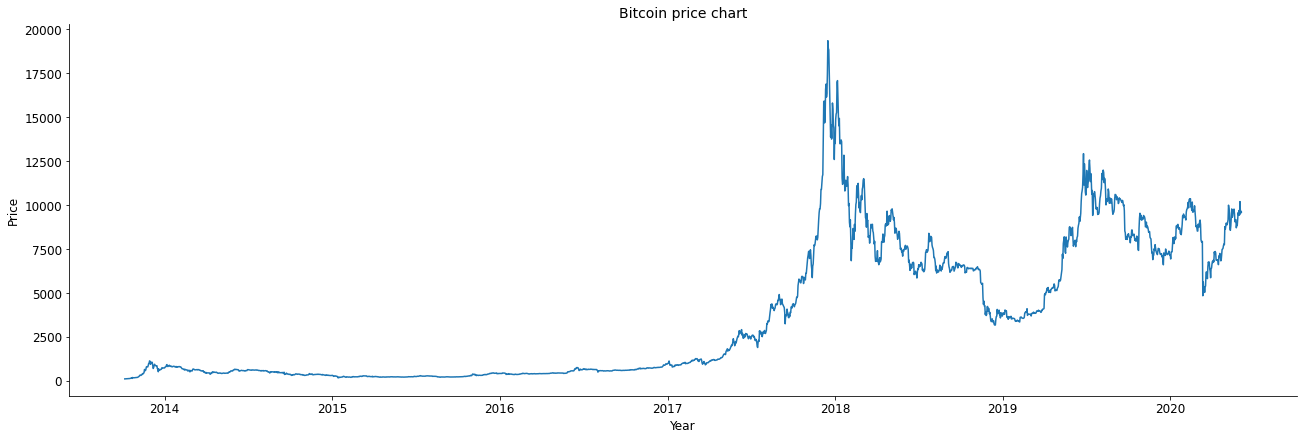

In [11]:
fig, ax = plt.subplots(constrained_layout=True)
plt.title('Bitcoin price chart')
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(btc)
ax.set_xlabel('Year')
ax.set_ylabel('Price') 
plt.show()

In [12]:
rolling_mean = btc.rolling(window = 12).mean()
rolling_std = btc.rolling(window = 12).std()
print(rolling_mean,rolling_std)

                  price
timestamp              
2013-10-06          NaN
2013-10-07          NaN
2013-10-08          NaN
2013-10-09          NaN
2013-10-10          NaN
...                 ...
2020-05-31  9227.725000
2020-06-01  9285.733333
2020-06-02  9324.741667
2020-06-03  9366.000000
2020-06-04  9402.625000

[2434 rows x 1 columns]                  price
timestamp             
2013-10-06         NaN
2013-10-07         NaN
2013-10-08         NaN
2013-10-09         NaN
2013-10-10         NaN
...                ...
2020-05-31  311.419916
2020-06-01  416.053328
2020-06-02  414.630461
2020-06-03  422.286441
2020-06-04  423.612514

[2434 rows x 1 columns]


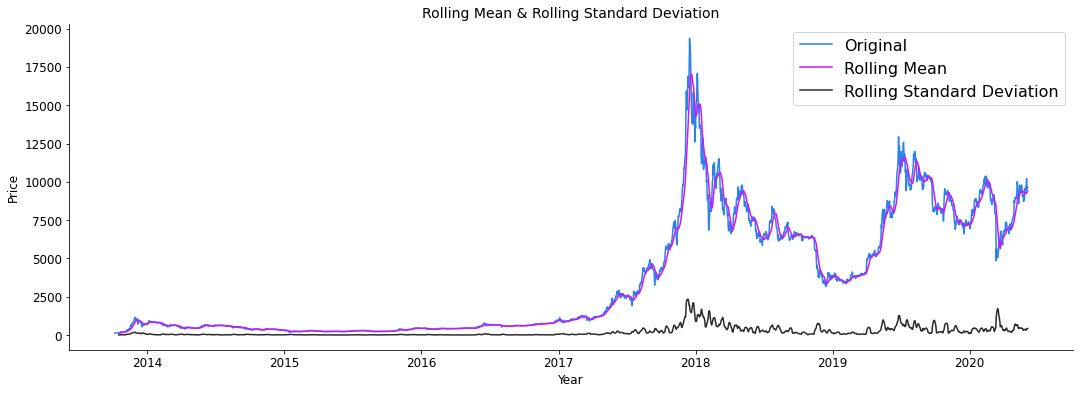

In [13]:
plt.plot(btc, color = '#2a83e8', label = 'Original')
plt.plot(rolling_mean, color = '#d014fa', label = 'Rolling Mean')
plt.plot(rolling_std, color = '#2b2b2e', label = 'Rolling Standard Deviation')
plt.legend(loc = 'best')
plt.xlabel('Year')
plt.ylabel('Price') 
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [14]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
result = adfuller(btc['price'], autolag='AIC')
result_output = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in result[4].items():
    result_output['Critical Value (%s)'%key] = value    
print(result_output)

Results of Dickey Fuller Test:
Test Statistic                   -1.502704
p-value                           0.532173
#Lags Used                       27.000000
Number of Observations Used    2406.000000
Critical Value (1%)              -3.433071
Critical Value (5%)              -2.862742
Critical Value (10%)             -2.567410
dtype: float64


The ADF statistics are far from critical and the p-value is greater than the threshold (0,05). Therefore, we can conclude that the time series is not stationary.



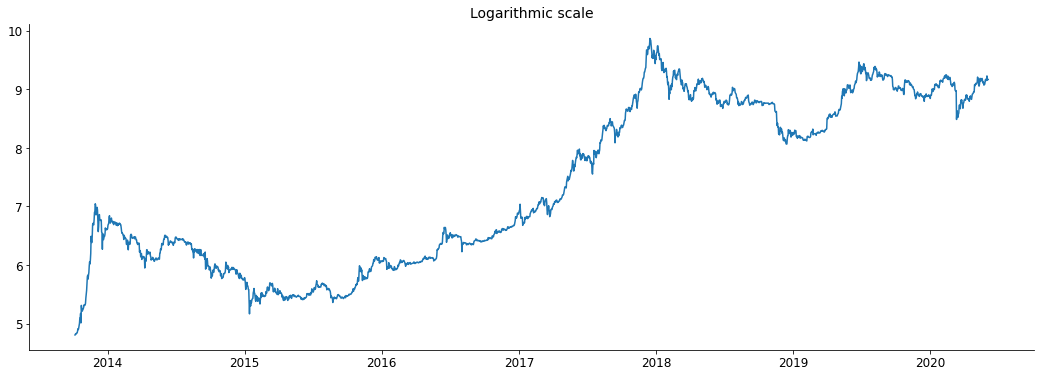

In [15]:
btc_log = np.log(btc)

plt.title('Logarithmic scale')
plt.plot(btc_log)
plt.show()

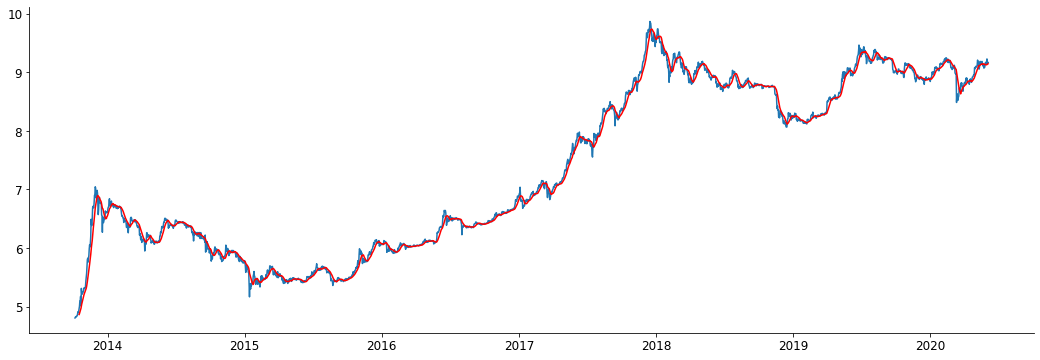

In [16]:
#The below transformation is required to make series stationary
movingAverage = btc_log.rolling(window=12).mean()
movingSTD = btc_log.rolling(window=12).std()
plt.plot(btc_log)
plt.plot(movingAverage, color='red')
plt.show()

We will create a function that will run two tests that will determine whether a given time series is stationary.

In [17]:
btcLogMinusMovingAverage = btc_log - movingAverage
btcLogMinusMovingAverage.head(12)

#Remove NAN values
btcLogMinusMovingAverage.dropna(inplace=True)
btcLogMinusMovingAverage.head(10)

,price
timestamp,
2013-10-17,0.105287
2013-10-18,0.124457
2013-10-19,0.190874
2013-10-20,0.168093
2013-10-21,0.217324
2013-10-22,0.041036
2013-10-23,0.300333
2013-10-24,0.184581
2013-10-25,0.141265


In [18]:
def test_stationarity(timeseries):
    
    # rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='#2a83e8', label='Original')
    mean = plt.plot(movingAverage, color='#d014fa', label='Rolling Mean')
    std = plt.plot(movingSTD, color='#2b2b2e', label='Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('\nResults of Dickey Fuller Test:')
    result = adfuller(timeseries['price'], autolag='AIC')
    result_output = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in result[4].items():
        result_output['Critical Value (%s)'%key] = value
    print(result_output)

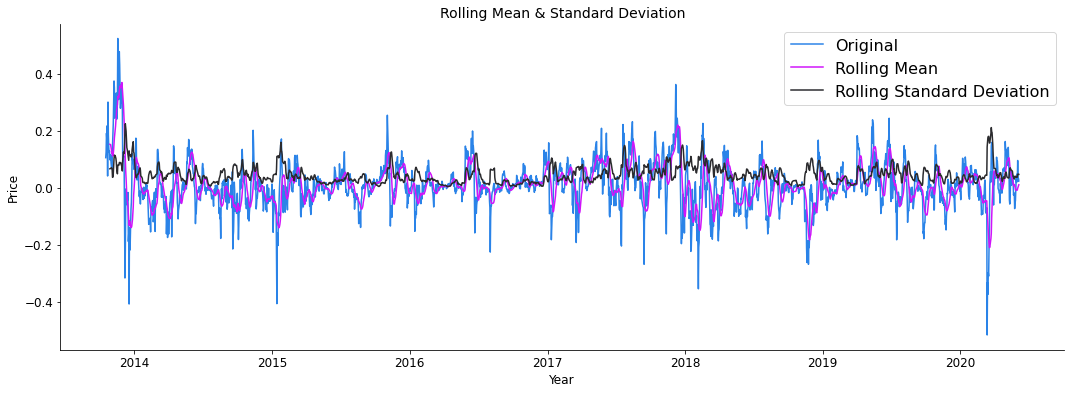


Results of Dickey Fuller Test:
Test Statistic                -1.037373e+01
p-value                        2.229398e-18
#Lags Used                     9.000000e+00
Number of Observations Used    2.413000e+03
Critical Value (1%)           -3.433063e+00
Critical Value (5%)           -2.862739e+00
Critical Value (10%)          -2.567408e+00
dtype: float64


In [19]:
test_stationarity(btcLogMinusMovingAverage)

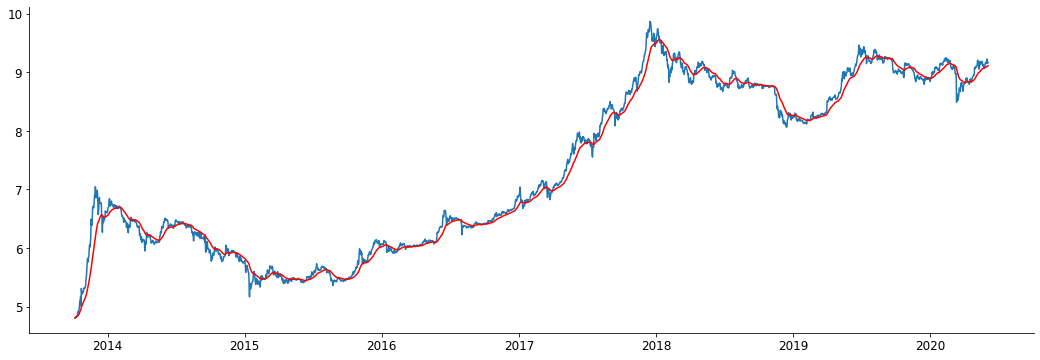

In [20]:
exponentialDecayWeightedAverage = btc_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(btc_log)
plt.plot(exponentialDecayWeightedAverage, color='red')
plt.show()

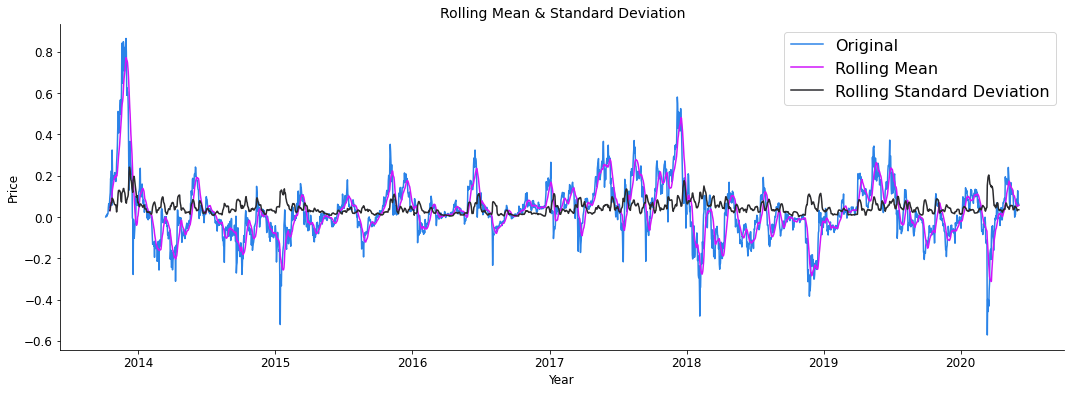


Results of Dickey Fuller Test:
Test Statistic                -6.922387e+00
p-value                        1.137711e-09
#Lags Used                     6.000000e+00
Number of Observations Used    2.427000e+03
Critical Value (1%)           -3.433047e+00
Critical Value (5%)           -2.862732e+00
Critical Value (10%)          -2.567404e+00
dtype: float64


In [21]:
btcLogMinusExponentialMovingAverage = btc_log - exponentialDecayWeightedAverage
test_stationarity(btcLogMinusExponentialMovingAverage)

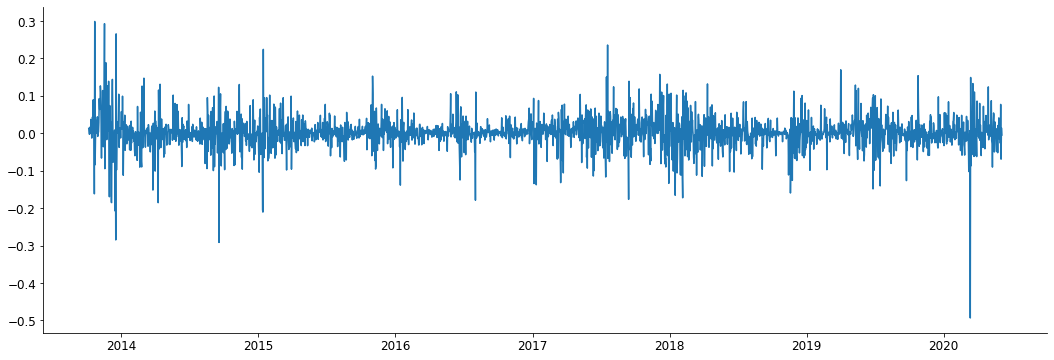

In [22]:
btcLogDiffShifting = btc_log - btc_log.shift()
plt.plot(btcLogDiffShifting)
plt.show()

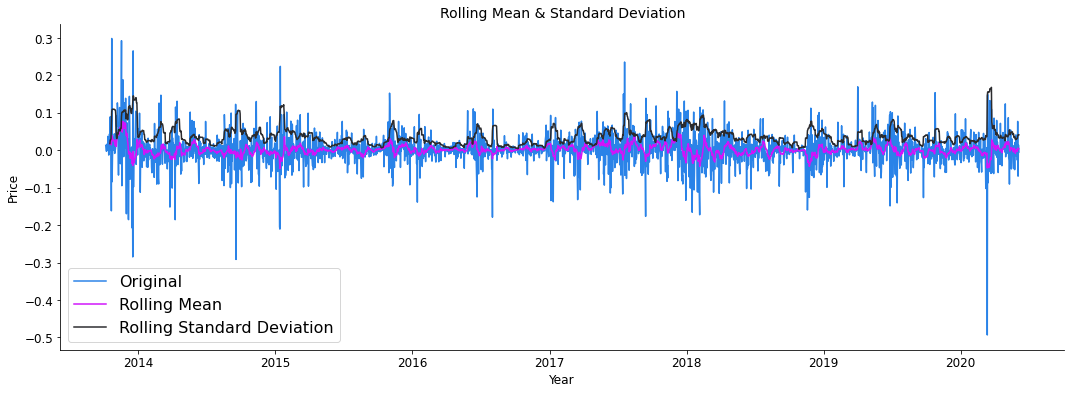


Results of Dickey Fuller Test:
Test Statistic                -1.291511e+01
p-value                        3.981183e-24
#Lags Used                     1.000000e+01
Number of Observations Used    2.422000e+03
Critical Value (1%)           -3.433053e+00
Critical Value (5%)           -2.862734e+00
Critical Value (10%)          -2.567406e+00
dtype: float64


In [23]:
btcLogDiffShifting.dropna(inplace=True)
test_stationarity(btcLogDiffShifting)

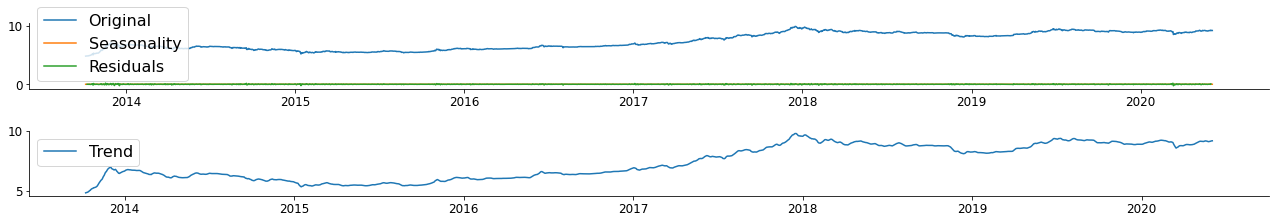

In [24]:
decomposition = seasonal_decompose(btc_log) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(btc_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

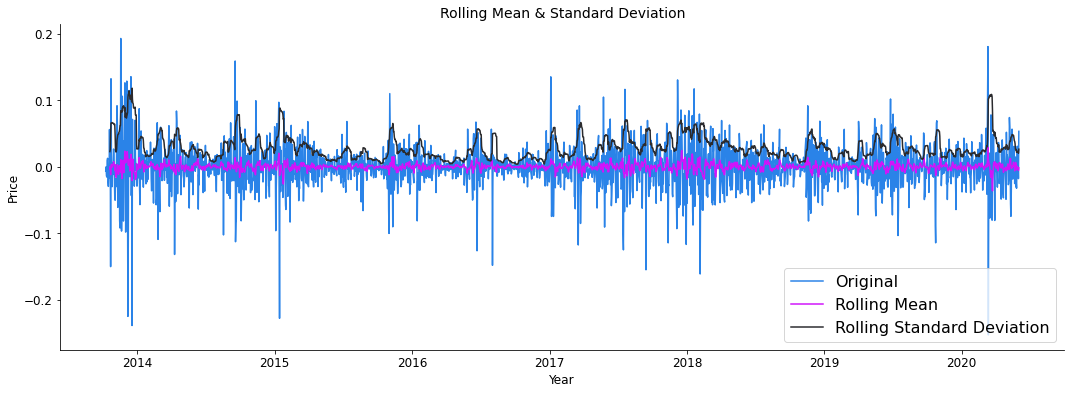


Results of Dickey Fuller Test:
Test Statistic                -1.552883e+01
p-value                        2.234069e-28
#Lags Used                     2.300000e+01
Number of Observations Used    2.404000e+03
Critical Value (1%)           -3.433073e+00
Critical Value (5%)           -2.862743e+00
Critical Value (10%)          -2.567410e+00
dtype: float64


In [25]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

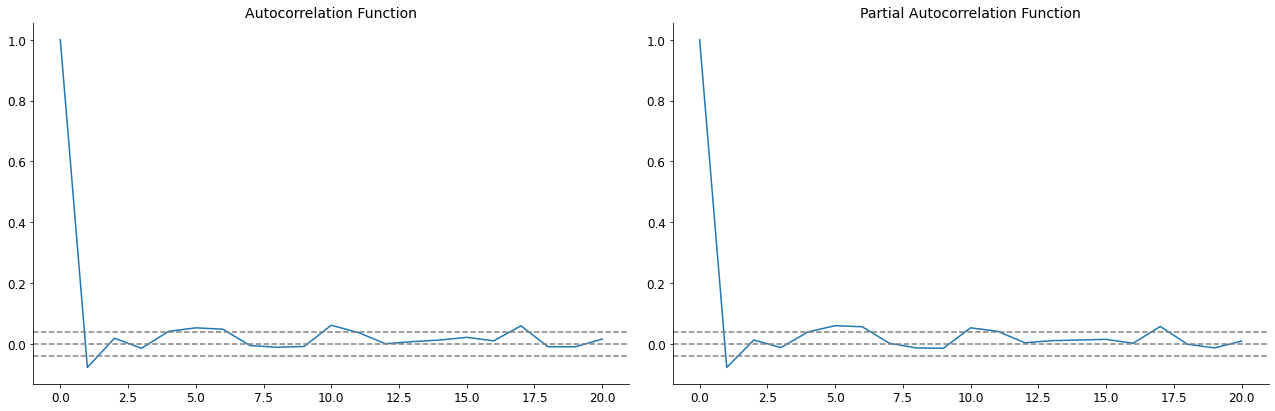

In [26]:
#ACF & PACF plots
lag_acf = acf(btcLogDiffShifting, nlags=20)
lag_pacf = pacf(btcLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(btcLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(btcLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(btcLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(btcLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

Plotting AR model


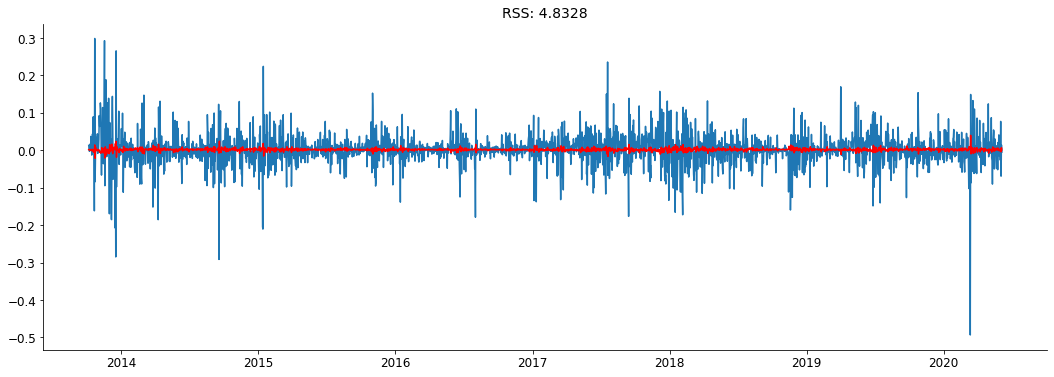

In [27]:
#AR Model
#acf=1, pacf=1
model = ARIMA(btc_log, order=(1,1,0))
results_AR = model.fit(disp=-1)
plt.plot(btcLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - btcLogDiffShifting['price'])**2))
print('Plotting AR model')

Plotting AR model


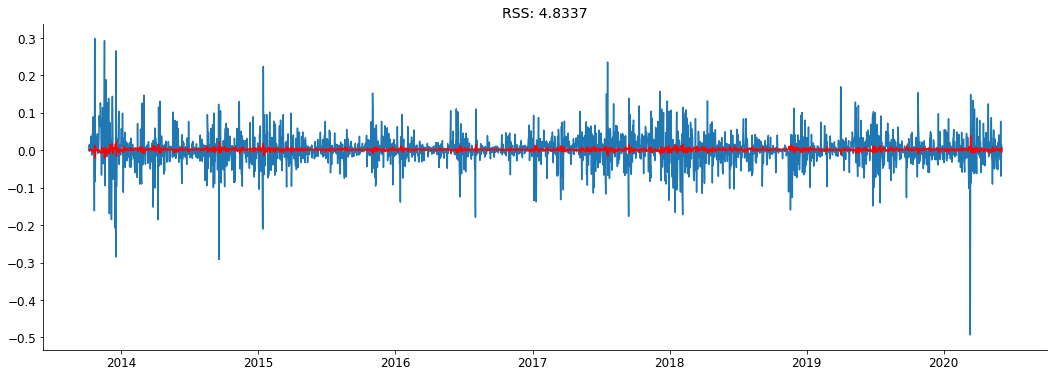

In [28]:
#AR Model
#acf=1, pacf=1
model = ARIMA(btc_log, order=(0,1,1))
results_AR = model.fit(disp=-1)
plt.plot(btcLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - btcLogDiffShifting['price'])**2))
print('Plotting AR model')

Plotting AR model


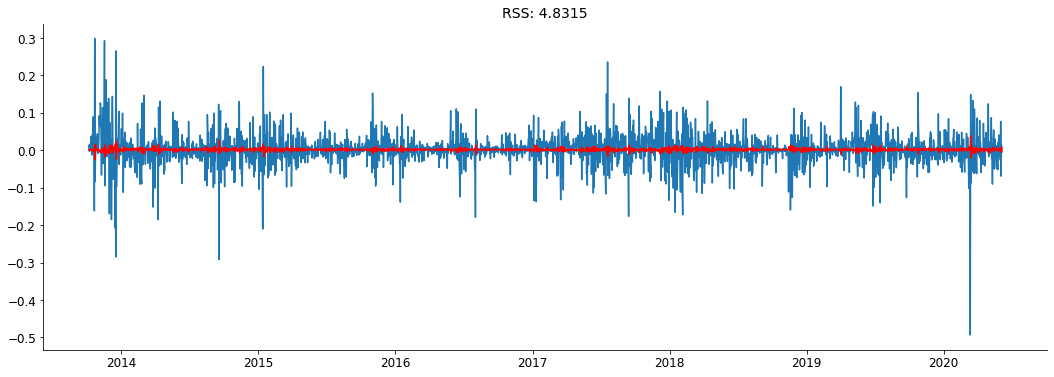

In [29]:
#AR Model
#acf=1, pacf=1
model = ARIMA(btc_log, order=(1,1,1))
results_AR = model.fit(disp=-1)
plt.plot(btcLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - btcLogDiffShifting['price'])**2))
print('Plotting AR model')

Plotting AR model


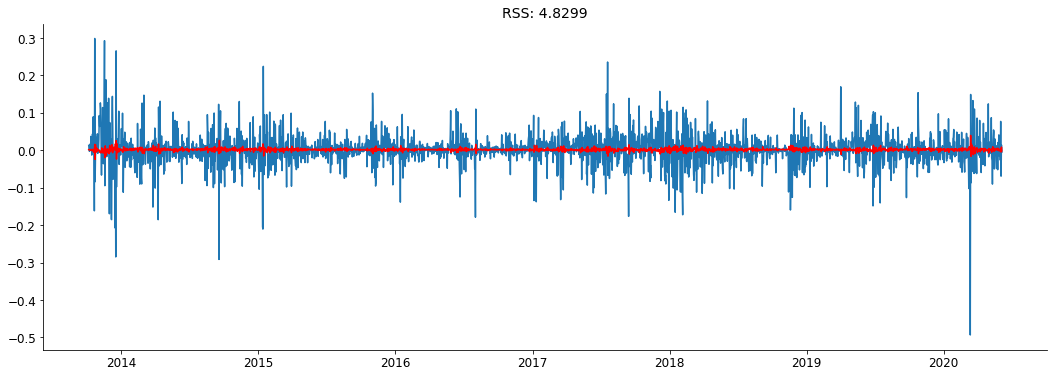

In [30]:
#AR Model
#acf=1, pacf=1
model = ARIMA(btc_log, order=(2,1,2))
results_AR = model.fit(disp=-1)
plt.plot(btcLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - btcLogDiffShifting['price'])**2))
print('Plotting AR model')

In [31]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

timestamp
2013-10-07    0.001795
2013-10-08    0.000921
2013-10-09    0.001739
2013-10-10    0.002019
2013-10-11    0.000721
dtype: float64


In [32]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

timestamp
2013-10-07    0.001795
2013-10-08    0.002716
2013-10-09    0.004455
2013-10-10    0.006474
2013-10-11    0.007195
                ...   
2020-05-31    4.359666
2020-06-01    4.364016
2020-06-02    4.359332
2020-06-03    4.368097
2020-06-04    4.366591
Length: 2433, dtype: float64


In [33]:
predictions_ARIMA_log = pd.Series(btc_log['price'].iloc[0], index=btc_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

timestamp
2013-10-06    4.804021
2013-10-07    4.805816
2013-10-08    4.806737
2013-10-09    4.808476
2013-10-10    4.810495
dtype: float64

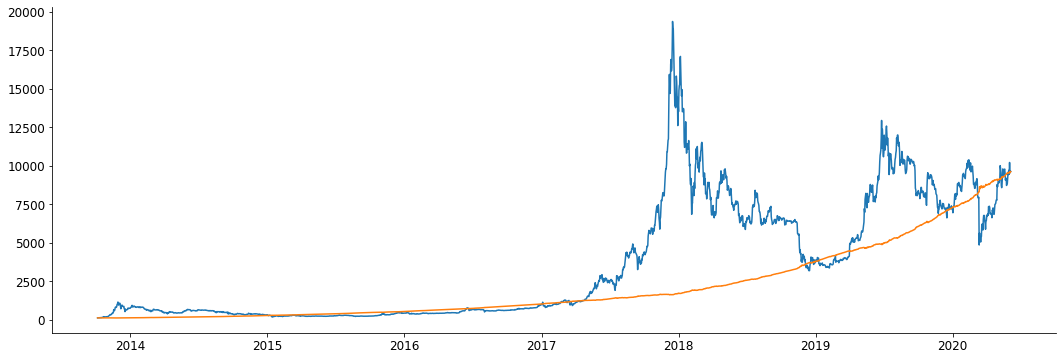

In [34]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(btc)
plt.plot(predictions_ARIMA)
plt.show()

In [35]:
btc_log

,price
timestamp,
2013-10-06,4.804021
2013-10-07,4.817131
2013-10-08,4.821732
2013-10-09,4.818990
2013-10-10,4.835170
...,...
2020-05-31,9.153495
2020-06-01,9.230751
2020-06-02,9.161717


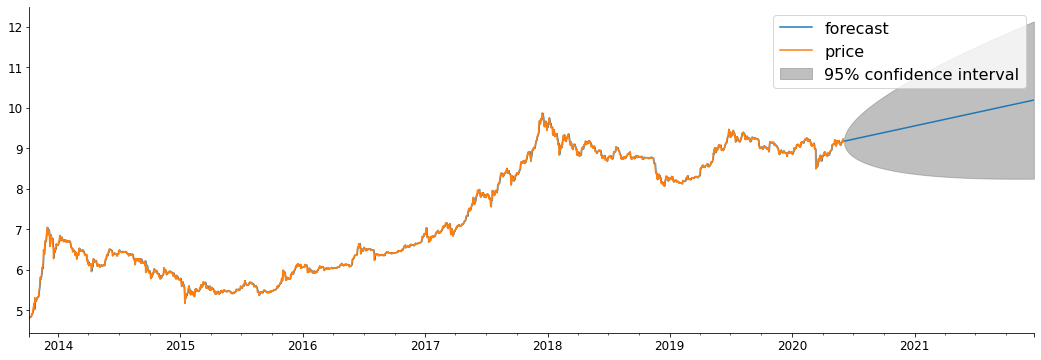

In [36]:
results_AR.plot_predict(1,3000)
plt.show()